# Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch import optim

import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [3]:
source_X = pd.read_csv("./data/1_X_train.csv").values
target_X = pd.read_csv("./data/2_X_train.csv").values

source_y_task = pd.read_csv("./data/1_Y_train.csv").values.reshape(-1)
target_y_task = pd.read_csv("./data/2_Y_train.csv").values.reshape(-1)

In [4]:
source_loader, target_loader, source_y_task, source_X, target_X, target_y_task = utils.get_loader(source_X, target_X, source_y_task, target_y_task)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [5]:
hidden_size = 10
num_domains = 1
num_classes = 1
dropout_ratio = 0.5

feature_extractor = utils.Encoder(input_size=source_X.shape[1], output_size=hidden_size).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [6]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

# Domain Invariant Learning

In [7]:
num_epochs = 1000

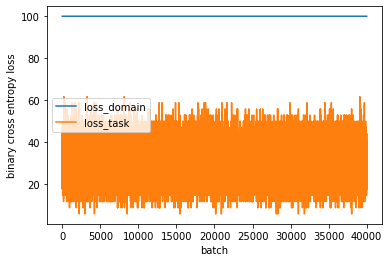

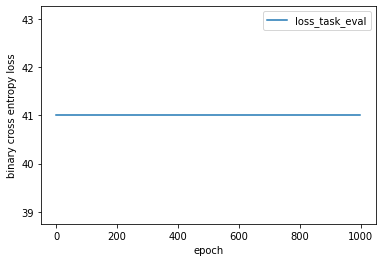

In [8]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, target_X, target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs)

# Domain Adaptation Accuracy

In [9]:
target_feature_eval = feature_extractor(target_X)
pred_y_task = task_classifier(target_feature_eval)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5

acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Accuracy:{acc}")

Accuracy:0.5899234414100647


# Without Adaptation

In [10]:
task_classifier = utils.Decoder(input_size=source_X.shape[1], output_size=num_classes).to(device)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

In [11]:
task_classifier = utils.fit_task_classifier(source_loader, task_classifier, task_optimizer, criterion, num_epochs)

In [12]:
pred_y_task = task_classifier(target_X)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Without Adaptation Accuracy:{acc}")

Without Adaptation Accuracy:0.5899234414100647


# t-SNE Visualization for Extracted Feature

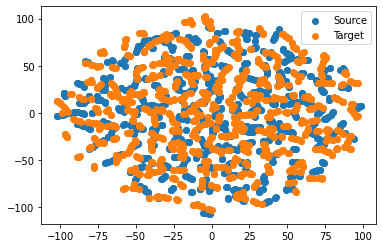

In [14]:
utils.visualize_tSNE(target_feature_eval, source_X, feature_extractor)